In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

import os
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime

# Verify GPU is detected

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Force TF to only allocate memory as needed on the GPU, otherwise TF attempts to allocate all the memory incase it needs it.
TF using all the memory leads to the "Failed to get convolution algorithm. This is probably because cuDNN failed to initialize," error.
Note that if RTX Voice (or other GPU memory heavy application) isn't running then this isn't needed.

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7168)])
    except RuntimeError as e:
        print(e)

# Training parameters

In [5]:
BATCH_SIZE = 8
EPOCHS = 100

# Image size in pixels.
IMG_HEIGHT = 224
IMG_WIDTH = 244

# Number of images in the training set.
N_TRAIN = 481

# Number of image classes / categories.
CLASS_COUNT = 9

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

# Extra note added to the details file.
EXTRA_NOTES = "Transfer Learning, Cross"

# Load Data

In [6]:
# Directories of data, each catergory / class of data is in a seperate folder.
# TRAINING_DIR = "training_data/training"
# VALIDATION_DIR = "training_data/validation"
TRAINING_DIR = "reduced_training_data/training"
VALIDATION_DIR = "reduced_training_data/validation"

In [7]:
# Rescale here refers to scaling the pixel values from a range of [0, 255] to a range of [0, 1].
train_image_generator = ImageDataGenerator(rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [8]:
train_data_gen_batches = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=TRAINING_DIR,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode="rgb",
                                                           class_mode='categorical',
                                                           )

Found 481 images belonging to 9 classes.


In [9]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=VALIDATION_DIR,
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="rgb",
                                                              class_mode='categorical')

Found 117 images belonging to 9 classes.


# Model Layers

In [21]:
# Base already trained model.

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 244, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 245, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 122, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 122, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [22]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(CLASS_COUNT, activation='softmax')



In [23]:
model = tf.keras.Sequential([
    base_model,
    global_avg_layer,
    prediction_layer
])



# Compile Model

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


# Tensorboard Logging + Model Summary 

In [26]:
# log_dir = "logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
# model.summary()

# Setup Checkpointing the Model

In [28]:
def get_details():
    DETAILS = "batch_size={}_epochs={}_img=({},{})".format(BATCH_SIZE, EPOCHS, IMG_HEIGHT, IMG_WIDTH)
    return DETAILS

In [31]:
TIMESTAMP = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

BASE_CHECKPOINT_PATH = "checkpoints"

CHECKPOINT_FILE_NAME = "cp-{epoch:04d}.ckpt"
CHECKPOINT_PATH = os.path.join(BASE_CHECKPOINT_PATH, TIMESTAMP, CHECKPOINT_FILE_NAME)
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_PATH)

os.makedirs(CHECKPOINT_DIR)

DETAIL_FILE_NAME = "details.txt"
details_file = open(os.path.join(CHECKPOINT_DIR, DETAIL_FILE_NAME), "w")

# General information to the details file.
details_file.write(TIMESTAMP + "\n")
details_file.write(get_details() + "\n")
details_file.write(EXTRA_NOTES + "\n")

# Save the model summary to the details file.
details_file.write("MODEL SUMMARY\n")
model.summary(print_fn=lambda x: details_file.write(x))
details_file.close()

MODEL_FINAL_SAVE_PATH = os.path.join(BASE_CHECKPOINT_PATH, "final_model")

# Train the model

In [32]:
history = model.fit(train_data_gen_batches, epochs=EPOCHS, validation_data = val_data_gen, verbose = 1, callbacks=[cp_callback])


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 61 steps, validate for 15 steps
Epoch 1/100
61/61 [==============================] - 7s 115ms/step - loss: 1.6495 - accuracy: 0.8607 - val_loss: 2.0569 - val_accuracy: 0.3248
Epoch 2/100
61/61 [==============================] - 7s 115ms/step - loss: 1.6441 - accuracy: 0.8669 - val_loss: 2.0555 - val_accuracy: 0.3248
Epoch 3/100
61/61 [==============================] - 7s 114ms/step - loss: 1.6397 - accuracy: 0.8690 - val_loss: 2.0552 - val_accuracy: 0.3248
Epoch 4/100
61/61 [==============================] - 7s 115ms/step - loss: 1.6344 - accuracy: 0.8711 - val_loss: 2.0546 - val_accuracy: 0.3162
Epoch 5/100
61/61 [==============================] - 7s 115ms/step - loss: 1.6294 - accuracy: 0.8815 - val_loss: 2.0521 - val_accuracy: 0.3248
Epoch 6/100
61/61 [==============================] - 7s 115ms/step - loss: 1.6248 - accuracy: 0.8877 - val_loss: 2.0528 - val_accuracy: 0.3248
Epoch 7/100
60/61 [============================>.]

61/61 [==============================] - 8s 128ms/step - loss: 1.4889 - accuracy: 0.9522 - val_loss: 2.0260 - val_accuracy: 0.3504
Epoch 53/100
61/61 [==============================] - 8s 123ms/step - loss: 1.4873 - accuracy: 0.9501 - val_loss: 2.0261 - val_accuracy: 0.3504
Epoch 54/100
61/61 [==============================] - 7s 116ms/step - loss: 1.4858 - accuracy: 0.9501 - val_loss: 2.0277 - val_accuracy: 0.3675
Epoch 55/100
61/61 [==============================] - 7s 117ms/step - loss: 1.4840 - accuracy: 0.9522 - val_loss: 2.0252 - val_accuracy: 0.3761
Epoch 56/100
61/61 [==============================] - 7s 118ms/step - loss: 1.4828 - accuracy: 0.9501 - val_loss: 2.0248 - val_accuracy: 0.3761
Epoch 57/100
60/61 [============================>.] - ETA: 0s - loss: 1.4800 - accuracy: 0.9556
Epoch 00057: saving model to checkpoints\19-07-2020-22-06-18\cp-0057.ckpt
INFO:tensorflow:Assets written to: checkpoints\19-07-2020-22-06-18\cp-0057.ckpt\assets
61/61 [=============================

# Save the Model 

In [33]:
model.save(MODEL_FINAL_SAVE_PATH)

INFO:tensorflow:Assets written to: checkpoints\final_model\assets


# Display Results

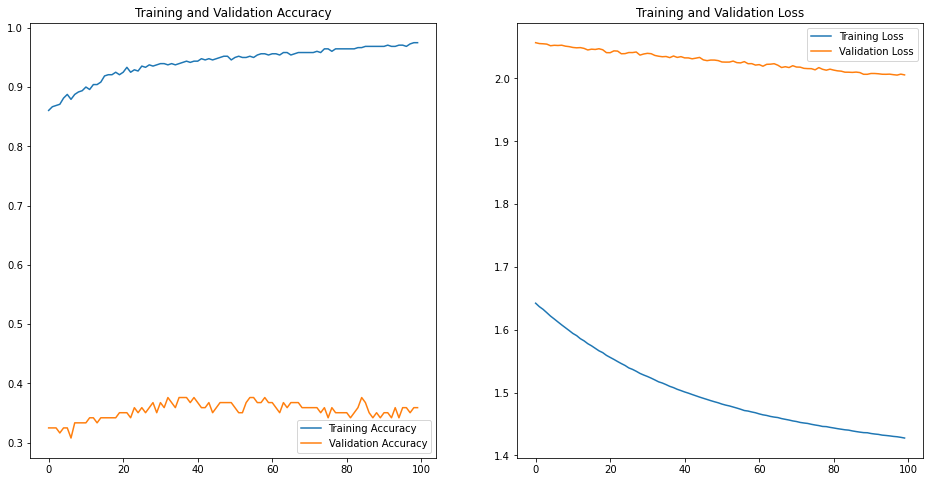

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

file_name = "graph.png"

plt.savefig(os.path.join(CHECKPOINT_DIR, file_name))

plt.show()

# Make some test predictions

In [35]:
TEST_DIR = "reduced_training_data/test"
TEST_CLASSES = ["707-320", "737-800", "777-200", "a330-200", "bae 146-300", "c-130", "eurofighter typhoon", "md-80", "spitfire"]

In [36]:
def plot_prediction(ax, prediction, actual, title):
    patches, texts, autotexts = ax.pie(prediction, labels=None, explode=[0.1] * len(prediction), autopct='%1.1f%%', shadow=True)
    
    ax.set_title(title)
#     ax.axis('equal')
    ax.legend(patches, TEST_CLASSES, bbox_to_anchor=(1.75, 0.5), loc="center right")
    

In [37]:
# This function will plot images in the form of a grid with 1 row and 3 columns.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [38]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=1,
                                                              directory=TEST_DIR,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="rgb",
                                                              class_mode='categorical')

Found 24 images belonging to 9 classes.


In [39]:
# plt.figure()
# test_images, _ = peek(test_data_gen)
# plotImages(test_images[:3])

In [40]:
predictions = model.predict(test_data_gen)
actual_classes = test_data_gen.classes

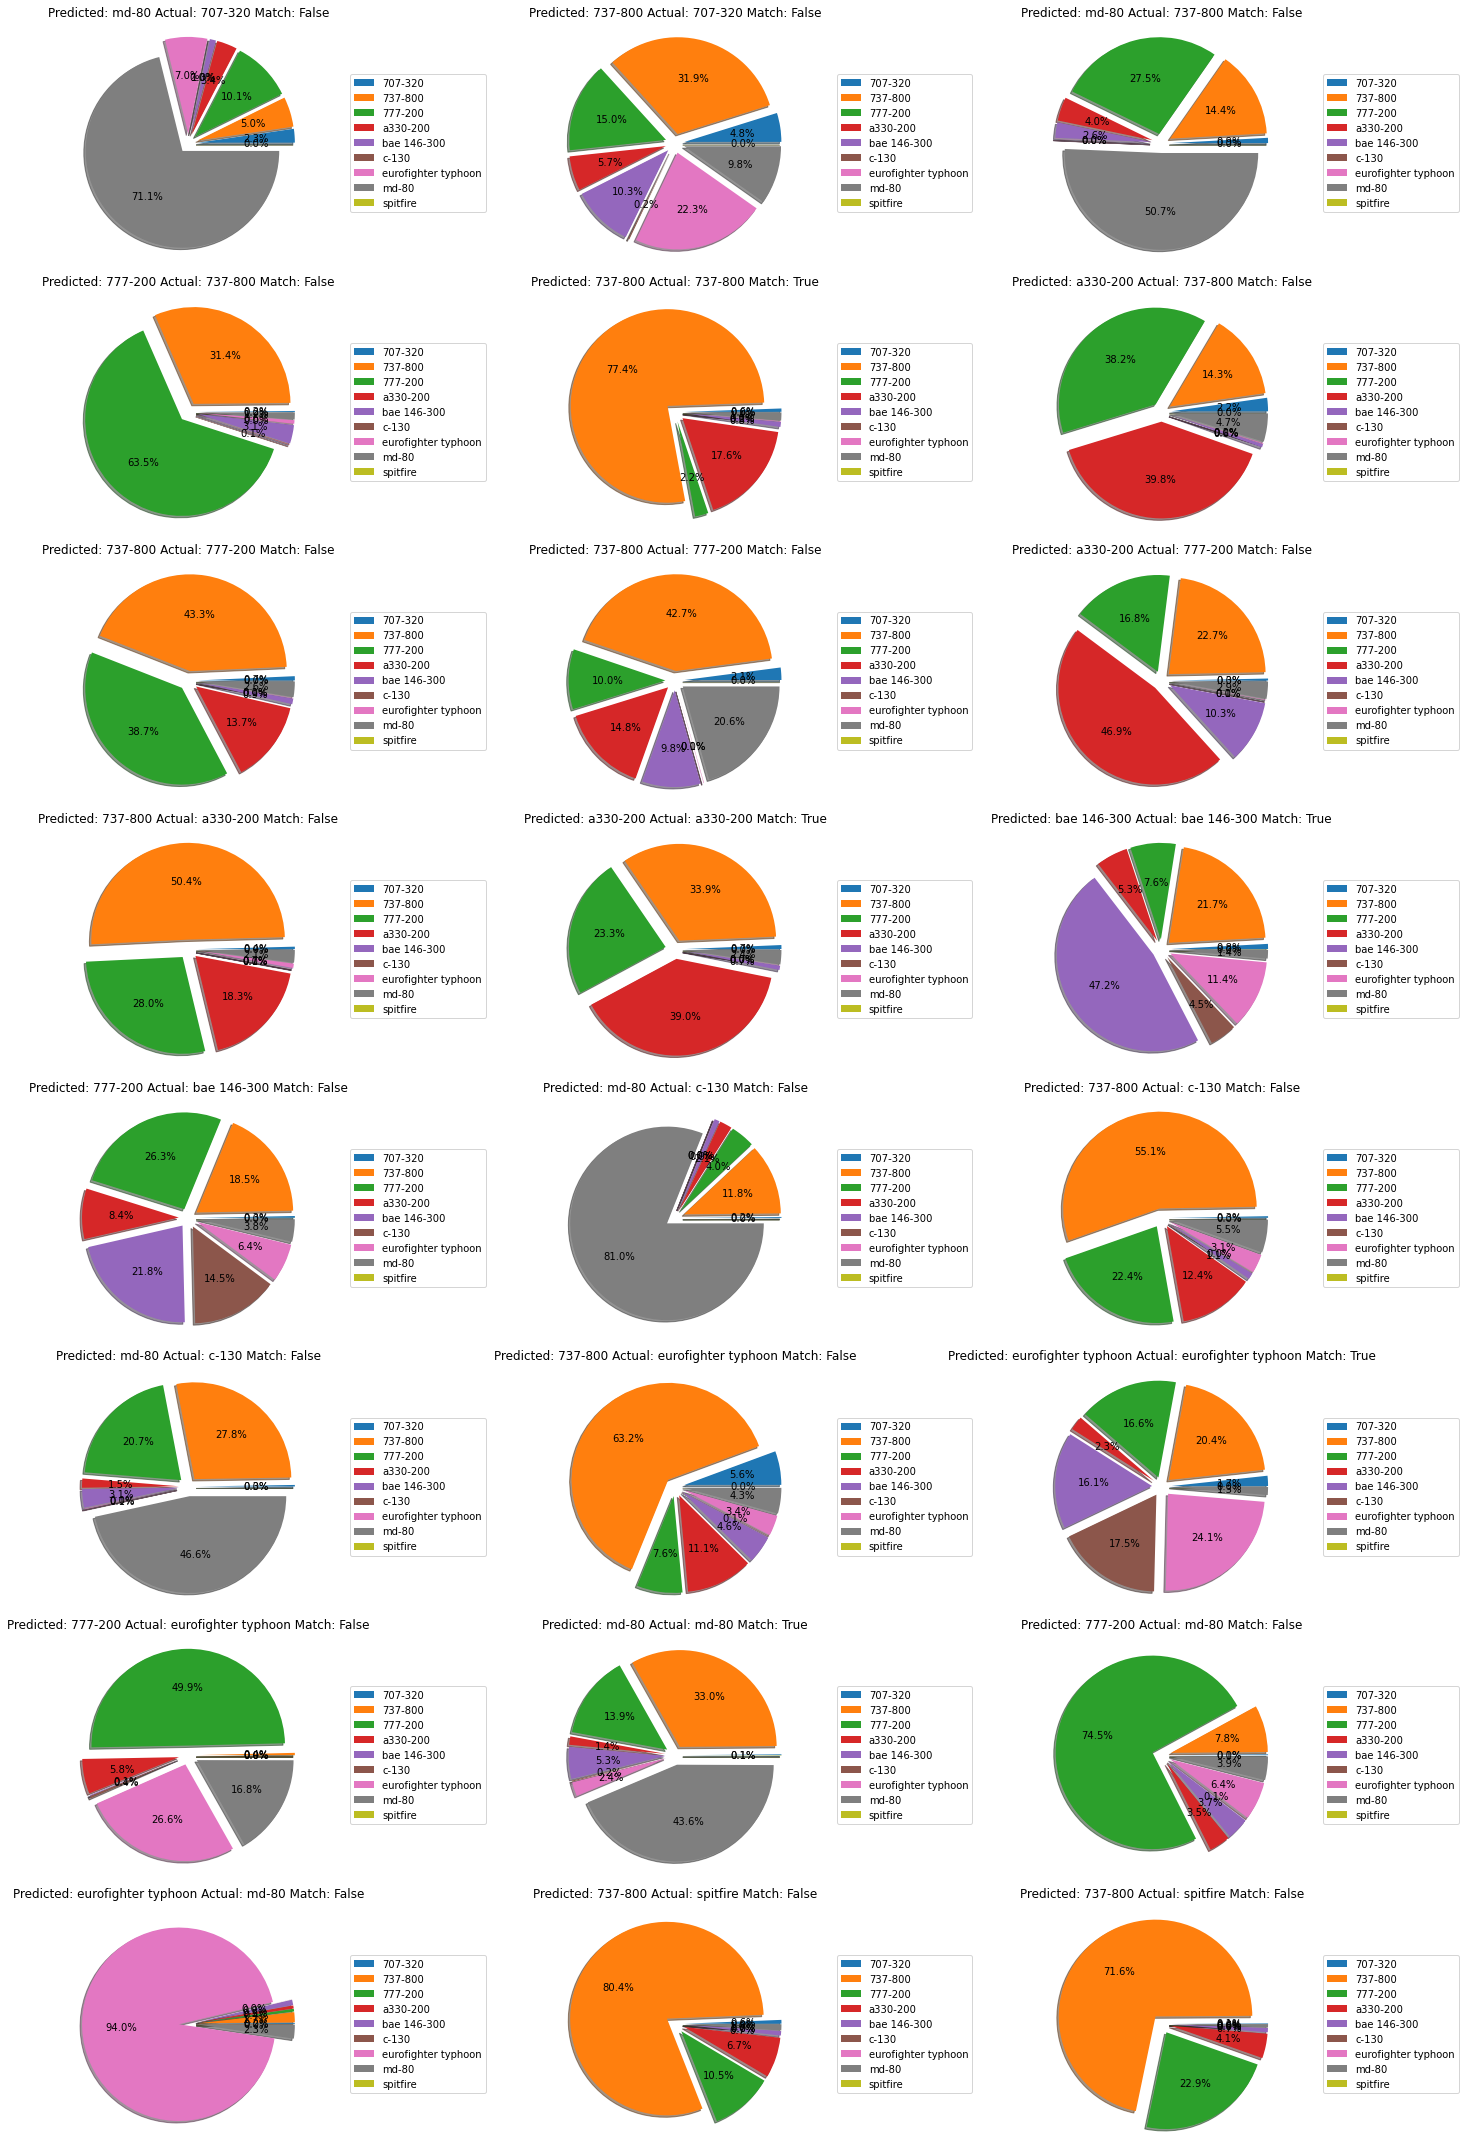

In [41]:
nrows = 3
ncol = 3

fig, ax = plt.subplots(math.ceil(len(predictions) / nrows), ncol, figsize=(20,30))

for index, predic in enumerate(predictions):
    predicted = np.argmax(predic)
    actual = actual_classes[index]
    title = "Predicted: {} Actual: {} Match: {}".format(TEST_CLASSES[predicted], TEST_CLASSES[actual], predicted==actual)
#     fig.figure(figsize=(6,24))
#     fig, ax = subplot(len(predictions), 1, index + 1)
    a = ax[int(index / nrows)][index % ncol]
    plot_prediction(a, predic, actual, title)

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, "test_results.pdf"), dpi=300, bbox_inches='tight')
plt.show()
